In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# tqdm (https://tqdm.github.io/) is a progress bar
# useful when dealing with long "for loop"

# Choose a style for plots
plt.style.use('default')

## Runge-Kutta 4th order

$$
\begin{cases}
    dx    &= F(x) \\
    dx'   &= F(x + \frac{\delta t}{2} dx) \\
    dx''  &= F(x + \frac{\delta t}{2} dx') \\
    dx''' &= F(x + \delta t \, dx'')
\end{cases}
\quad \longrightarrow \quad
x_{i+1} = x_i +
\frac{\delta t}{6} dx + 
\frac{\delta t}{3} dx' + 
\frac{\delta t}{3} dx'' + 
\frac{\delta t}{6} dx'''
$$

In [2]:
def RK4(x, F, dt):
    # intermediate timesteps for Runge-Kutta 4 
    dx0 = F(x)
    dx1 = F(x + dt/2 * dx0)
    dx2 = F(x + dt/2 * dx1)
    dx3 = F(x + dt * dx2)
    
    # combine steps using right coefficients
    return x + dt/6 * dx0 + dt/3 * dx1 + dt/3 * dx2 + dt/6 * dx3

----

# Lorenz system

$$
\vec{x} = \text{position vector}
\qquad
\dot{\vec{x}} = F(\vec{x})
\qquad
\Longleftrightarrow
\qquad
\begin{cases}
    \dot{x} &= -\sigma x + \sigma y \\
    \dot{y} &= r x - y - x z \\
    \dot{z} &= -b z + x y \\
\end{cases}
$$

In [3]:
# Parameters for Lorenz equations
o = 10
b = 8/3
r = 28

# Lorenz equations
def F(x):
    return np.array([
        -o * x[0] + o * x[1],            # x[0]'
        +r * x[0] - x[1] - x[0] * x[2],  # x[1]'
        -b * x[2] + x[0] * x[1]          # x[2]'
    ])

In [4]:
# Integrate Lorenz equations for time N x dt where
# N is the Number of timestep while
# dt is the length of each one.
N = 100_000
dt = 0.001

# X is a N x 3 matrix containg the trajectory of
# point in 3d space according to Lorenz equations.
# Rows are different time while columns are
# the three components of the point.

# Allocate the matrix in advance yield faster results
# (Python does not have to enlarge by itself)
X = np.empty(3 * N).reshape(N, 3)

# Initial conditions
X[0] = [0.1, 0.2, 0.3]

# Integrate using Runge-Kutta 4
for i in range(N-1):
    X[i+1] = RK4(X[i], F, dt)

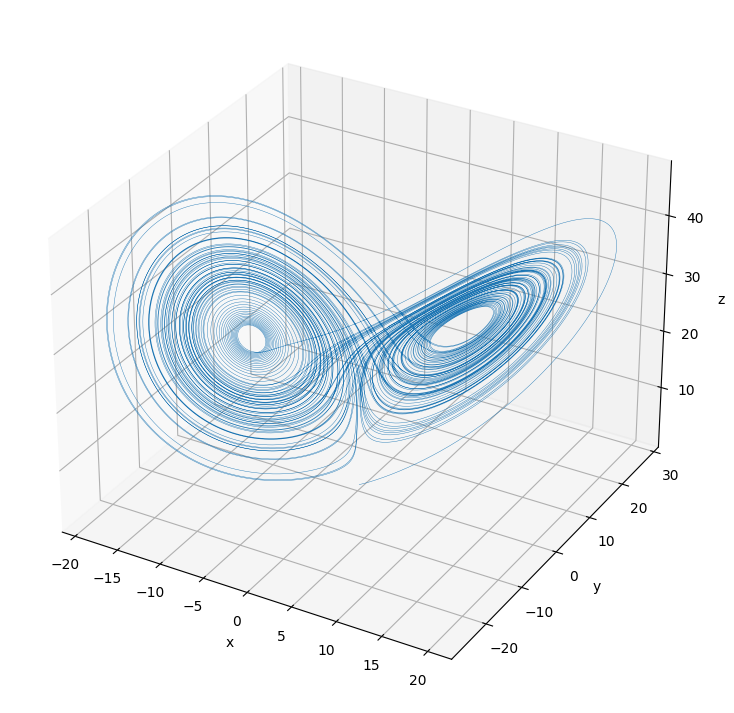

In [5]:
fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection="3d")
ax.plot3D(*X.T, linewidth=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Lyapuov exponents

$$
\vec{x} = \text{position vector + 3 perturbations}
\qquad
\dot{\vec{x}} = F(\vec{x})
\qquad
\Longleftrightarrow
\qquad
\begin{cases}
    \dot{x} &= -\sigma x + \sigma y \\
    \dot{y} &= r x - y - x z \\
    \dot{z} &= -b z + x y \\
    \\
    d\dot{x_1} &= -\sigma \, dx_1 + \sigma \, dy_1 \\
    d\dot{y_1} &= r \, dx_1 - dy_1 - (dx_1 \, z + x \, dz_1) \\
    d\dot{z_1} &= -b \, dz_1 + (dx_1 \, y + x \, dy_1) \\
    \\
    d\dot{x_2} &= -\sigma \, dx_2 + \sigma \, dy_2 \\
    d\dot{y_2} &= r \, dx_2 - dy_2 - (dx_2 \, z + x \, dz_2) \\
    d\dot{z_2} &= -b \, dz_2 + (dx_2 \, y + x \, dy_2) \\
    \\
    d\dot{x_3} &= -\sigma \, dx_3 + \sigma \, dy_3 \\
    d\dot{y_3} &= r \, dx_3 - dy_3 - (dx_3 \, z + x \, dz_3) \\
    d\dot{z_3} &= -b \, dz_3 + (dx_3 \, y + x \, dy_3) \\
\end{cases}
$$

In [6]:
def F(x):    
    position = [
        -o * x[0][0] + o * x[0][1],                                    # x[0][0]'
        +r * x[0][0] - x[0][1] - x[0][0] * x[0][2],                    # x[0][1]'
        -b * x[0][2] + x[0][0] * x[0][1]                               # x[0][2]'
    ]
    perturbations = [
        [
            -o * dx[0] + o * dx[1],                                    # dx[0]'
            +r * dx[0] - dx[1] - (dx[0] * x[0][2] + x[0][0] * dx[2]),  # dx[1]'
            -b * dx[2] + (dx[0] * x[0][1] + x[0][0] * dx[1])           # dx[2]'
        ]
        for dx in x[1:4]
    ]
    return np.array([position, *perturbations])

In [7]:
# WARNING!: With these values of N and dt this cell take ~ 3 min to run.

N = 1_000_000
dt = 0.001

X = np.empty(3 * 4 * N).reshape(N, 4, 3)   # (x, y, z) * (pos + 3 perturbations) * (N timesteps)
L = np.zeros(3 * N).reshape(N, 3)          # (3 Lyapunov exps) * (N timesteps)

# Initial conditions
X[0] = [
    [0.1, 0.2, 0.3], # position at (x, y, z)
    [1, 0, 0],       # perturbation along x
    [0, 1, 0],       # perturbation along y
    [0, 0, 1],       # perturbation along z
]
     
    
for i in tqdm(range(N-1)):
    
    X[i+1] = RK4(X[i], F, dt)
    
    nx = np.linalg.norm(X[i+1][1])
    X[i+1][1] /= nx                                        # normalization

    X[i+1][2] -= X[i+1][1] * np.dot(X[i+1][2], X[i+1][1])  # remove component along x
    ny = np.linalg.norm(X[i+1][2])
    X[i+1][2] /= ny                                        # normalization
    
    X[i+1][3] -= X[i+1][1] * np.dot(X[i+1][3], X[i+1][1])  # remove component along x
    X[i+1][3] -= X[i+1][2] * np.dot(X[i+1][3], X[i+1][2])  # remove component along y
    nz = np.linalg.norm(X[i+1][3])
    X[i+1][3] /= nz                                        # normalization

    L[i+1] = L[i] + np.log([nx, ny, nz])                   # Lyapunov exp without division by t

# Divide Lyapunov exp at t by the corresponding time
for i in range(1, N):
    L[i] /= i * dt

100%|█████████████████████████████████████████████████████████████████████████| 999999/999999 [03:28<00:00, 4796.69it/s]


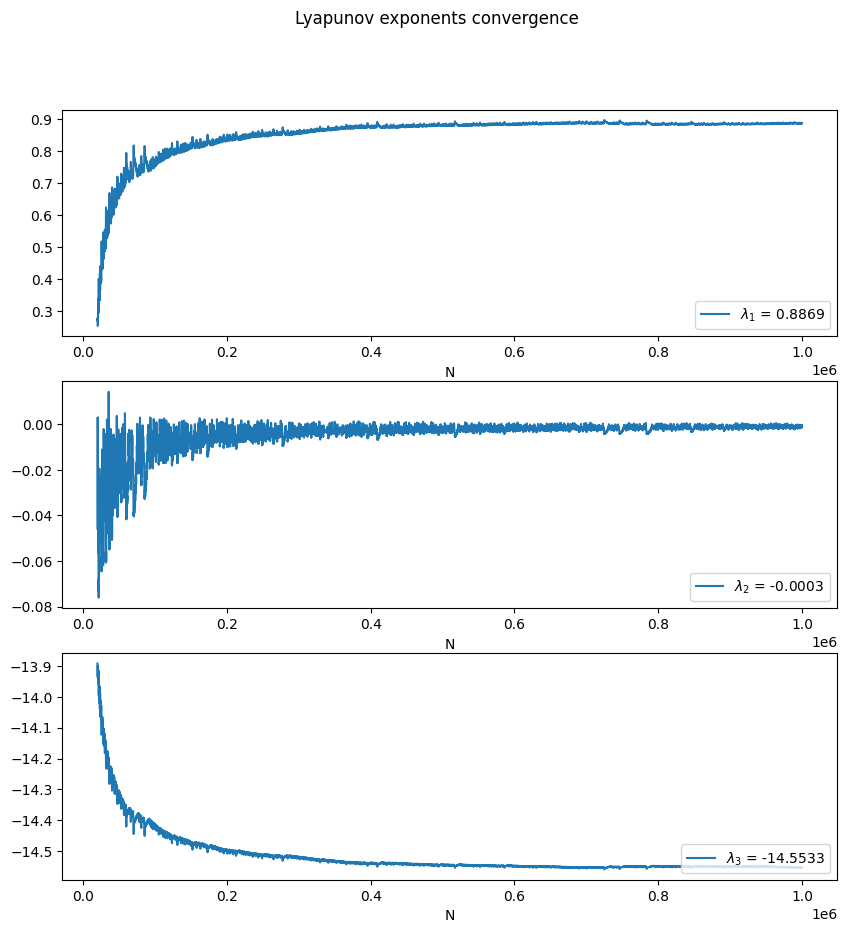

In [8]:
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Lyapunov exponents convergence')

# Big oscillation of Lyapunov exps for lower value of N
# are not show in the following plots. The plot starts
# from 1/50 of N and end at N.

for i, ax in enumerate(axs):
    label = f'$\lambda_{i+1}$ = {L[-1][i]:.4f}'
    ax.plot(range(N//50, N), L[N//50:, i], label=label)
    ax.legend(loc='lower right')
    ax.set_xlabel('N')

plt.show()

## Attractor reconstruction with delayed coordinates

$$
\begin{cases}
    \dot{x} &= -\sigma x + \sigma y \\
    \dot{y} &= r x - y - x z \\
    \dot{z} &= -b z + x y \\
\end{cases}
\qquad
\Longrightarrow
\qquad
\begin{cases}
    \tilde{x} \ (t) = x \ (t)  \\
    \tilde{y} \ (t) = x \ (t - \tau) \\
    \tilde{y} \ (t) = x \ (t - 2 \tau) \\
\end{cases}
$$

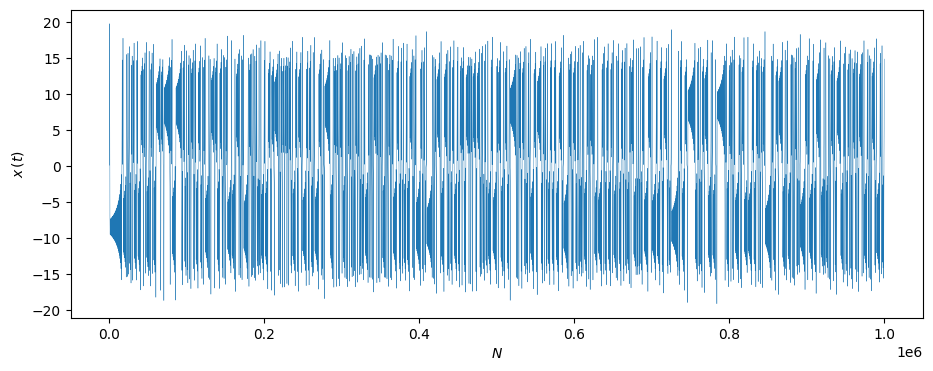

In [9]:
x = X[:,0,0]

fig = plt.figure(figsize=(11, 4))
ax = plt.axes()
ax.plot(range(N), x, linewidth=0.3)
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$x \, (t)$')
plt.show()

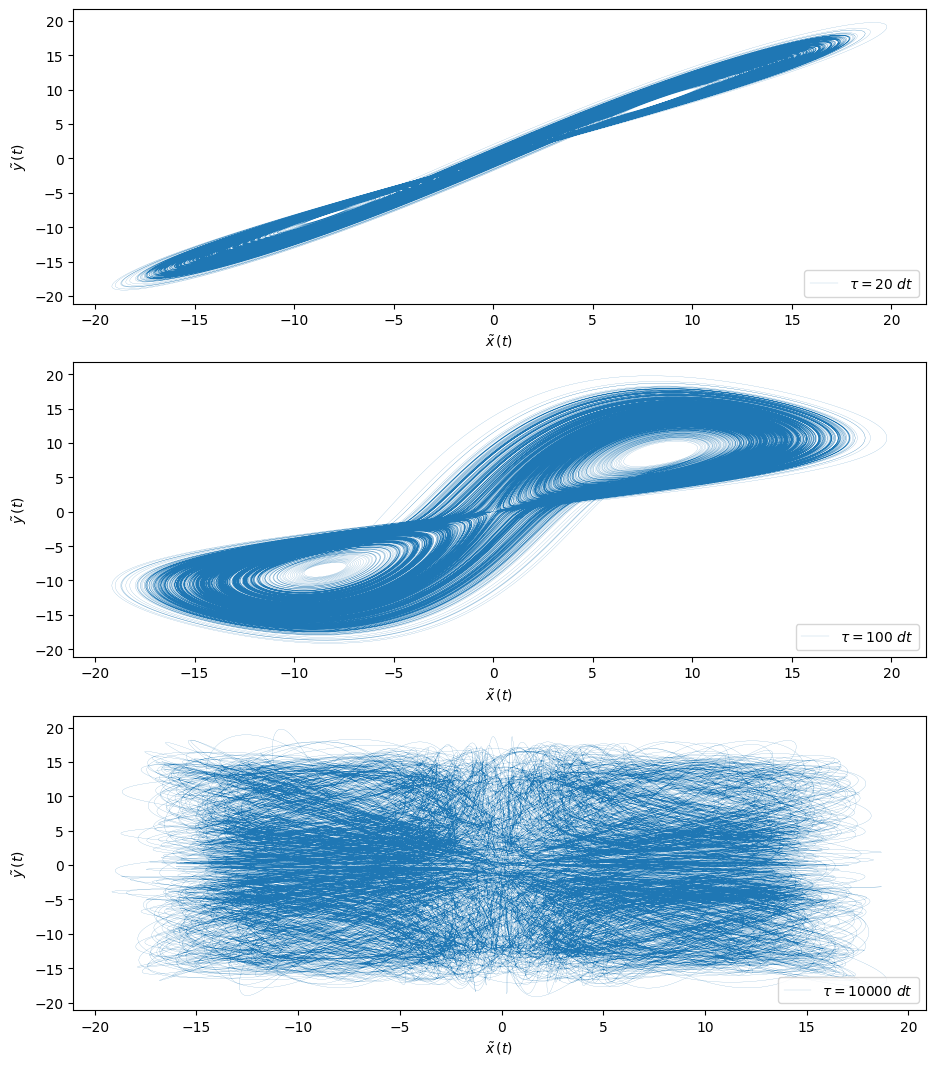

In [10]:
fig, axs = plt.subplots(3, figsize=(11,13))

for ax, tau in zip(axs, [20, 100, 10000]):
    label = fr'$\tau = {tau} \ dt$'
    ax.plot(x[tau:], x[:-tau], label=label, linewidth=0.1)
    ax.set_xlabel(r'$\tilde{x} \, (t)$')
    ax.set_ylabel(r'$\tilde{y} \, (t)$')
    ax.legend(loc='lower right')

plt.show()

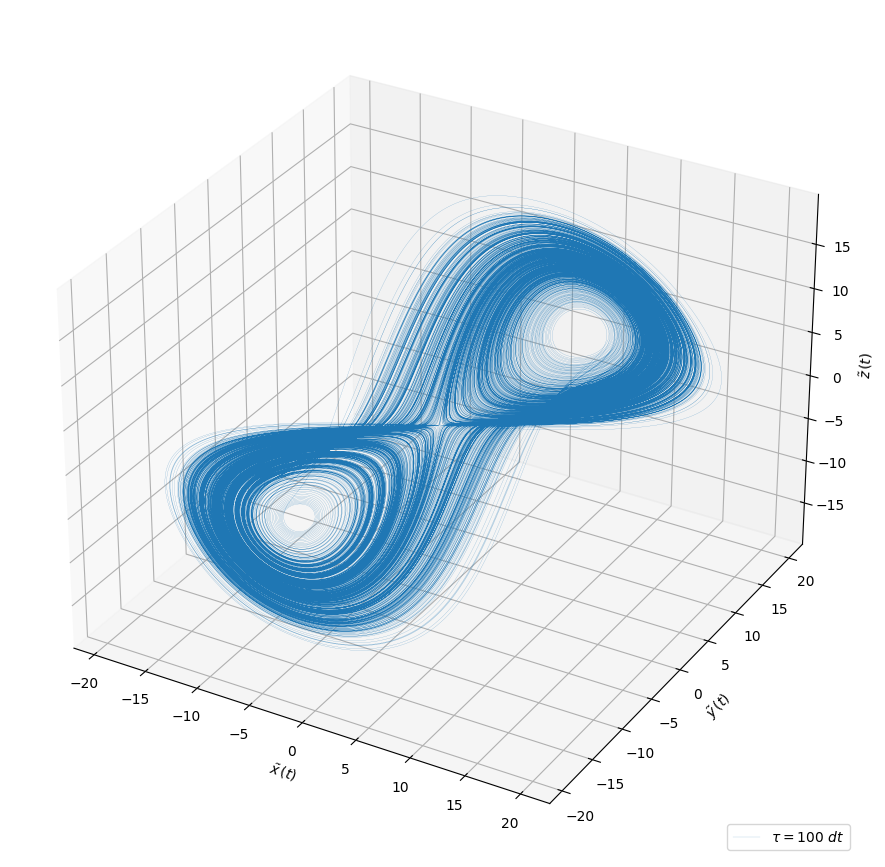

In [11]:
tilde_X = np.array([x[200:], x[100: -100], x[:-200]])
fig = plt.figure(figsize=(11, 11))
ax = plt.axes(projection="3d")
label = r'$\tau = 100 \ dt$'
ax.plot3D(*tilde_X, linewidth=0.1, label=label)
ax.set_xlabel(r'$\tilde{x} \, (t)$')
ax.set_ylabel(r'$\tilde{y} \, (t)$')
ax.set_zlabel(r'$\tilde{z} \, (t)$')
ax.legend(loc='lower right')
plt.show()